In [1]:
import pandas as pd  #pandas does things with matrixes
import numpy as np #used for sorting a matrix
import matplotlib.pyplot as plt #matplotlib is used for plotting data
import matplotlib.ticker as ticker #used for changing tick spacing
import datetime as dt #used for dates
import matplotlib.dates as mdates #used for dates, in a different way
import os #used for changes of directory
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, Multiply, Add, Activation, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras import optimizers

import sys
sys.path.append('../')
from utils import *

In [2]:
dataset_1yr = pd.read_csv("../../Data/all_stocks_5yr.csv")
dataset_1yr.head()

# Changing the date column to the datetime format (best format to work with time series)
dataset_1yr['Date'] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dataset_1yr['Date']]

dataset_1yr.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [3]:
# Assigning a mid price column with the mean of the Highest and Lowest values

dataset_1yr['Mid'] = (dataset_1yr['High'] + dataset_1yr['Low'])/2
dataset_1yr.head()

,Date,Open,High,Low,Close,Volume,Name,Mid
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM,92.165
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM,92.255
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM,92.340
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM,93.040
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM,93.945


In [4]:
# Getting rid of null columns

missing_data = pd.DataFrame(dataset_1yr.isnull().sum()).T
print(missing_data)

for index, column in enumerate(missing_data.columns):
    if missing_data.loc[0][index] != 0:
        dataset_1yr = dataset_1yr.drop(dataset_1yr.loc[dataset_1yr[column].isnull()].index)
        
missing_data = pd.DataFrame(dataset_1yr.isnull().sum()).T
print(missing_data)

   Date  Open  High  Low  Close  Volume  Name  Mid
0     0   384   208  227      0     406     0  358
   Date  Open  High  Low  Close  Volume  Name  Mid
0     0     0     0    0      0       0     0    0


In [5]:
# Let's analyze 3M stocks a bit deeper

MMM_stocks = dataset_1yr[dataset_1yr['Name'] == 'MMM']

MMM_stocks.head()

,Date,Open,High,Low,Close,Volume,Name,Mid
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM,92.165
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM,92.255
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM,92.340
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM,93.040
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM,93.945


In [6]:
# Creating a trend feature

trend_term = [0]
temp = 0
for term in range(len(MMM_stocks['Close']) - 1):
    temp = MMM_stocks['Close'].iloc[term + 1] - MMM_stocks['Close'].iloc[term]
    if temp > 0:
        trend_term.append(1)
    elif temp < 0:
        trend_term.append(-1)
    else:
        trend_term.append(0)

MMM_stocks['Trend_term'] = pd.DataFrame(np.array(trend_term))

In [7]:
# Creating a percent change column related to the closing price

percent_change_closing_price = MMM_stocks['Close'].pct_change()
percent_change_closing_price.fillna(0, inplace=True)
MMM_stocks['PC_change'] = pd.DataFrame(percent_change_closing_price)

# As we want to predict the closing price, let's add the target column as the close price shifted by 1

MMM_stocks['Target'] = MMM_stocks['Close'].shift(-1)

MMM_stocks = MMM_stocks.drop(0, axis = 0)
MMM_stocks = MMM_stocks.drop('Name', axis = 1)
MMM_stocks = MMM_stocks.drop('Date', axis = 1)

MMM_stocks.head()

,Open,High,Low,Close,Volume,Mid,Trend_term,PC_change,Target
1,92.36,92.50,92.01,92.30,1843476.0,92.255,-1.0,-0.001082,92.54
2,92.00,92.74,91.94,92.54,1983395.0,92.340,1.0,0.002600,93.74
3,92.75,93.87,92.21,93.74,3395145.0,93.040,1.0,0.012967,94.24
4,93.93,94.30,93.59,94.24,3069513.0,93.945,1.0,0.005334,93.89
5,94.00,94.17,93.55,93.89,1640008.0,93.860,-1.0,-0.003714,93.21


In [8]:
# Separating as Training and Testing

train_data = MMM_stocks.iloc[:1000,:]
train_data = train_data.drop('Target',axis=1)
test_data = MMM_stocks.iloc[1000:,:]
test_data = test_data.drop('Target',axis=1)

y_train = MMM_stocks.iloc[:1000,-1]
y_test = MMM_stocks.iloc[1000:,-1]

print(train_data.shape)
print(test_data.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 8)
(256, 8)
(1000,)
(256,)


## Keras Dilated Convolutions (Temporal CNN) for time series prediction

### 1 step ahead prediction with univariate input

#### Scaling the data

In [128]:
# Scaling Data for the Univariate Example

# Training Data

scaler_dataframe = StandardScaler()
training_scaled = pd.DataFrame(scaler_dataframe.fit_transform(np.array(train_data['Close']).reshape(-1,1)))
#print(training_scaled.head())

# Testing Data
testing_scaled = pd.DataFrame(scaler_dataframe.transform(np.array(test_data['Close']).reshape(-1,1)))
#print(testing_scaled.head())

#### Data Pre-Processing
Rows for time steps and columns for parallel series (features)

In [129]:
# Preparing data for the experiment with an univariate model 
# Getting Closing Price and arranging lists for training/testing based on the sequence

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)  
    return np.array(X), np.array(y)

In [130]:
window_size = 20

train_univariate, y_train_univariate = split_sequence(np.array(training_scaled), window_size)
test_univariate, y_test_univariate = split_sequence(np.array(testing_scaled), window_size)

In [131]:
# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

# Choose a number of time steps
n_steps = train_univariate.shape[1]

X = train_univariate.reshape(train_univariate.shape[0], train_univariate.shape[1], n_features) # Reshaping array in order to have a 3D input
y = y_train_univariate

print(X.shape)
print(y.shape)

(980, 20, 1)
(980, 1)


#### Model fitting

In [135]:
# Defining model architecture

n_filters = 32
kernel_len = 3
dilation_rates = [1,2,4,8]

net_input = Input(shape=(window_size, n_features))
model_arch = net_input

for dilation_rate in dilation_rates:
    model_arch = Conv1D(filters=n_filters,
                   kernel_size=kernel_len, 
                   padding='causal',
                   dilation_rate=dilation_rate)(model_arch)

model_arch = Flatten()(model_arch)
model_arch = Dense(100, activation='relu')(model_arch)
model_arch = Dense(50, activation='relu')(model_arch)
#model_arch = Dropout(.2)(model_arch)
model_arch = Dense(1)(model_arch)

model = Model(inputs = net_input, outputs = model_arch)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
#                           decay=0.0, amsgrad=False)

print('\n\nModel with input size {}, output size {}'.
                            format(model.input_shape, model.output_shape))

model.summary()



Model with input size (None, 20, 1), output size (None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 20, 1)             0         
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 20, 32)            128       
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
flatten_14 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_49 (Dense

In [136]:
epochs = 100
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_univariate, 
                    y_train_univariate,
                    epochs=epochs)

Epoch 1/100
980/980 [==============================] - 3s 3ms/sample - loss: 0.1075
Epoch 2/100
980/980 [==============================] - 0s 481us/sample - loss: 0.0232
Epoch 3/100
980/980 [==============================] - 0s 455us/sample - loss: 0.0251
Epoch 4/100
980/980 [==============================] - 0s 444us/sample - loss: 0.0162
Epoch 5/100
980/980 [==============================] - 0s 450us/sample - loss: 0.0152
Epoch 6/100
980/980 [==============================] - 0s 445us/sample - loss: 0.0142
Epoch 7/100
980/980 [==============================] - 0s 446us/sample - loss: 0.0101
Epoch 8/100
980/980 [==============================] - 0s 438us/sample - loss: 0.0094
Epoch 9/100
980/980 [==============================] - 0s 457us/sample - loss: 0.0086
Epoch 10/100
980/980 [==============================] - 0s 455us/sample - loss: 0.0074
Epoch 11/100
980/980 [==============================] - 0s 455us/sample - loss: 0.0061
Epoch 12/100
980/980 [==============================] 

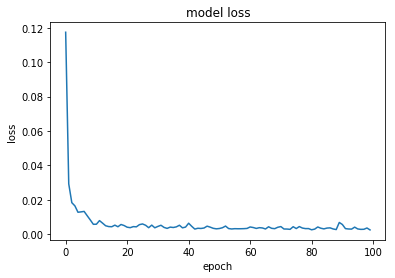

In [113]:
# Summarize history for loss

plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [140]:
# Lets define a function that will do a fit after each prediction

def walk_foward_prediction(model, epoch_update, test_x, true_label):   
    predictions = []
    for i in range(test_x.shape[0]):
        predictions.append(model.predict(test_x[i], verbose=0))
        _ = model.fit(test_x[i], true_label[i], epochs=epoch_update, verbose=0)
    return predictions

y_pred = []
epochs = 10

test = test_univariate.reshape((test_univariate.shape[0], 1, n_steps, n_features))
y_pred = walk_foward_prediction(model, epochs, test, y_test_univariate)

In [114]:
# Checking with only the testing data

y_pred = []

for i in range(test_univariate.shape[0]):
    test = test_univariate[i].reshape((1, n_steps, n_features))
    y_pred.append(model.predict(test, verbose=0))

In [141]:
horizon_predicted = scaler_dataframe.inverse_transform(np.array(y_pred).reshape(-1))
inverse_test_data = scaler_dataframe.inverse_transform(np.array(y_test_univariate).reshape(-1))
                                                       
MSE = mean_squared_error(inverse_test_data, horizon_predicted)
MAE = mean_absolute_error(inverse_test_data, horizon_predicted)
RMSE = np.sqrt(MSE)

TU_metric = TU(inverse_test_data, horizon_predicted)
POCID_metric = POCID(inverse_test_data, horizon_predicted)

print('Mean Squared Error (Testing Data): %.6f' % MSE)
print('Mean Absolute Error (Testing Data): %.6f' % MAE)
print('Root Mean Squared Error (Testing Data): %.6f' % RMSE)
print('TU: %.6f' % TU_metric)
print('Hit Rate Prediction of Change in Direction(POCID): %.6f' % POCID_metric)

Mean Squared Error (Testing Data): 3.292310
Mean Absolute Error (Testing Data): 1.309404
Root Mean Squared Error (Testing Data): 1.814472
TU: 1.527981
Hit Rate Prediction of Change in Direction(POCID): 50.212766


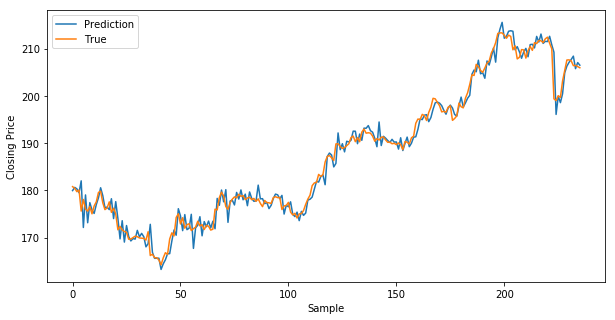

In [142]:
plt.figure(figsize = (10,5))

plt.plot(scaler_dataframe.inverse_transform(np.array(y_pred).reshape(-1)), label='Prediction')
plt.plot(scaler_dataframe.inverse_transform(np.array(y_test_univariate).reshape(-1)), label='True')
plt.xlabel('Sample')
plt.ylabel('Closing Price')
plt.legend(fontsize=10)

plt.show()

### Temporal CNN for 1 step ahead prediction with multivariate input

In [143]:
# Training Data

scaler_dataframe = StandardScaler()
training_scaled = pd.DataFrame(scaler_dataframe.fit_transform(np.array(MMM_stocks.iloc[:1000,:])))
#print(training_scaled.head())

# Testing Data
testing_scaled = pd.DataFrame(scaler_dataframe.transform(np.array(MMM_stocks.iloc[1000:,:])))
#print(testing_scaled.head())

# Scaler for the final output based on the closing price column for the training set

closing_price_scaler = StandardScaler()
scaler_output = closing_price_scaler.fit(np.array(MMM_stocks.iloc[:1000,:]['Close']).reshape(-1,1))

#### Data Pre-Processing
Rows for time steps and columns for parallel series (features)

In [144]:
# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [181]:
window_size = 20
n_features = 8

train_univariate, y_train_univariate = split_sequences(np.array(training_scaled), window_size)
test_univariate, y_test_univariate = split_sequences(np.array(testing_scaled), window_size)

print(train_univariate.shape)
print(y_train_univariate.shape)

(980, 20, 8)
(980,)


#### Model fitting

In [187]:
# Defining model architecture

n_filters = 32
kernel_len = 3
dilation_rates = [1,2,4,8]

net_input = Input(shape=(window_size, n_features))
model_arch = net_input

for dilation_rate in dilation_rates:
    model_arch = Conv1D(filters=n_filters,
                   kernel_size=kernel_len, 
                   padding='causal',
                   dilation_rate=dilation_rate)(model_arch)

model_arch = Flatten()(model_arch)
model_arch = Dense(128, activation='relu')(model_arch)
model_arch = Dense(50, activation='relu')(model_arch)
#model_arch = Dropout(.2)(model_arch)
model_arch = Dense(1)(model_arch)

model = Model(inputs = net_input, outputs = model_arch)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
#                           decay=0.0, amsgrad=False)

print('\n\nModel with input size {}, output size {}'.
                            format(model.input_shape, model.output_shape))

model.summary()



Model with input size (None, 20, 8), output size (None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 20, 8)             0         
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 20, 32)            800       
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 20, 32)            3104      
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 20, 32)            3104      
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 20, 32)            3104      
_________________________________________________________________
flatten_21 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_71 (Dense

In [190]:
epochs = 100
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_univariate, 
                    y_train_univariate,
                    epochs=epochs,
                    verbose=0)

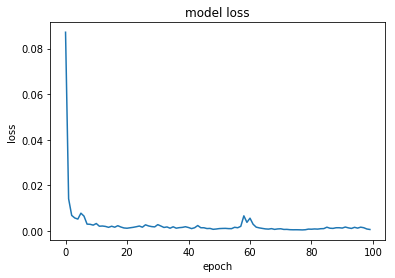

In [191]:
# Summarize history for loss

plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [153]:
# Using the Walk Foward Validation Strategy

y_pred = []
epochs = 10

test = test_univariate.reshape((test_univariate.shape[0], 1, window_size, n_features))
y_test = y_test_univariate.reshape(y_test_univariate.shape[0],1)

y_pred = walk_foward_prediction(model, epochs, test, y_test)

In [192]:
# Checking with the testing data

y_pred = []

for i in range(test_univariate.shape[0]):
    test = test_univariate[i].reshape((1, window_size, n_features))
    y_pred.append(model.predict(test, verbose=0))

In [193]:
horizon_predicted = scaler_output.inverse_transform(np.array(y_pred).reshape(-1))
inverse_test_data = scaler_output.inverse_transform(np.array(y_test_univariate).reshape(-1))
                                                       
MSE = mean_squared_error(inverse_test_data, horizon_predicted)
MAE = mean_absolute_error(inverse_test_data, horizon_predicted)
RMSE = np.sqrt(MSE)

TU_metric = TU(inverse_test_data, horizon_predicted)
POCID_metric = POCID(inverse_test_data, horizon_predicted)

print('Mean Squared Error (Testing Data): %.6f' % MSE)
print('Mean Absolute Error (Testing Data): %.6f' % MAE)
print('Root Mean Squared Error (Testing Data): %.6f' % RMSE)
print('TU: %.6f' % TU_metric)
print('Hit Rate Prediction of Change in Direction(POCID): %.6f' % POCID_metric)

Mean Squared Error (Testing Data): 5.180946
Mean Absolute Error (Testing Data): 1.772229
Root Mean Squared Error (Testing Data): 2.276169
TU: 2.403297
Hit Rate Prediction of Change in Direction(POCID): 50.638298


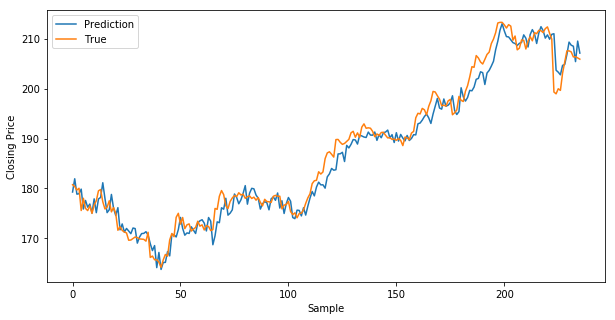

In [194]:
plt.figure(figsize = (10,5))

plt.plot(horizon_predicted, label='Prediction')
plt.plot(inverse_test_data, label='True')
plt.xlabel('Sample')
plt.ylabel('Closing Price')
plt.legend(fontsize=10)
plt.show()

In [207]:
# New Architecture to be evaluated (https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb)

n_filters = 32
kernel_len = 3
dilation_rates = [1,2,4,8]

# define an input history series and pass it through a stack of dilated causal convolution blocks. 

history_seq = Input(shape=(window_size, n_features))
x = history_seq
skips = []

for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=kernel_len, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=kernel_len, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)
out = Dense(1)(out)

model = Model(inputs = history_seq, outputs = out)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
#                           decay=0.0, amsgrad=False)

print('\n\nModel with input size {}, output size {}'.
                            format(model.input_shape, model.output_shape))

model.summary()



Model with input size (None, 20, 8), output size (None, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 20, 8)        0                                            
__________________________________________________________________________________________________
conv1d_183 (Conv1D)             (None, 20, 16)       144         input_35[0][0]                   
__________________________________________________________________________________________________
conv1d_184 (Conv1D)             (None, 20, 32)       1568        conv1d_183[0][0]                 
__________________________________________________________________________________________________
conv1d_185 (Conv1D)             (None, 20, 32)       1568        conv1d_183[0][0]                 
________________________________________________

In [208]:
epochs = 100
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_univariate, 
                    y_train_univariate,
                    epochs=epochs,
                    verbose=0)

Epoch 1/100
980/980 [==============================] - 6s 6ms/sample - loss: 0.1213
Epoch 2/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0200
Epoch 3/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0117
Epoch 4/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0110
Epoch 5/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0078
Epoch 6/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0069
Epoch 7/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0055
Epoch 8/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0062
Epoch 9/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0089
Epoch 10/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0064
Epoch 11/100
980/980 [==============================] - 1s 1ms/sample - loss: 0.0049
Epoch 12/100
980/980 [==============================] - 1s 1ms/sample - lo

In [205]:
# Checking with the testing data

y_pred = []

for i in range(test_univariate.shape[0]):
    test = test_univariate[i].reshape((1, window_size, n_features))
    y_pred.append(model.predict(test, verbose=0))

Mean Squared Error (Testing Data): 24.637510
Mean Absolute Error (Testing Data): 3.840884
Root Mean Squared Error (Testing Data): 4.963619
TU: 11.428657
Hit Rate Prediction of Change in Direction(POCID): 49.787234


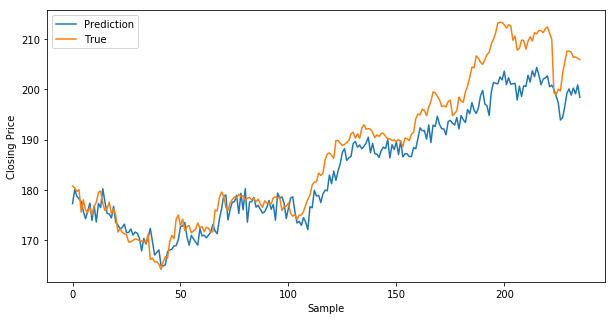

In [206]:
horizon_predicted = scaler_output.inverse_transform(np.array(y_pred).reshape(-1))
inverse_test_data = scaler_output.inverse_transform(np.array(y_test_univariate).reshape(-1))
                                                       
MSE = mean_squared_error(inverse_test_data, horizon_predicted)
MAE = mean_absolute_error(inverse_test_data, horizon_predicted)
RMSE = np.sqrt(MSE)

TU_metric = TU(inverse_test_data, horizon_predicted)
POCID_metric = POCID(inverse_test_data, horizon_predicted)

print('Mean Squared Error (Testing Data): %.6f' % MSE)
print('Mean Absolute Error (Testing Data): %.6f' % MAE)
print('Root Mean Squared Error (Testing Data): %.6f' % RMSE)
print('TU: %.6f' % TU_metric)
print('Hit Rate Prediction of Change in Direction(POCID): %.6f' % POCID_metric)

plt.figure(figsize = (10,5))

plt.plot(horizon_predicted, label='Prediction')
plt.plot(inverse_test_data, label='True')
plt.xlabel('Sample')
plt.ylabel('Closing Price')
plt.legend(fontsize=10)
plt.show()